In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter
import os

In [28]:
def draw_carbon_bridge_chart(city_name, years, carbon_emissions, decomposition_pct, output_dir="桥图"):
    """
    绘制碳排放贡献桥图
    
    参数:
    city_name: 城市名称 (str)
    carbon_emissions: 碳排放量列表 (list)
    decomposition_pct: 分解因素百分比字典 (dict)
    output_dir: 输出目录 (str)
    """
    # 确保输出目录存在
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 因素标签
    factor_labels = ['Energy Structure', 'Energy Intensity', 'Economy Effect', 'Population Effect']
    factor_colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2']  # 不同因素的颜色
    
    # 创建图表和双坐标轴
    fig, ax1 = plt.subplots(figsize=(16, 9))
    ax2 = ax1.twinx()  # 创建第二个y轴用于百分比
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    
    # 自定义y轴刻度格式（转换为K为单位）
    def k_formatter(x, pos):
        return f'{x/1000:.0f}K'
    
    # 应用自定义格式
    ax1.yaxis.set_major_formatter(FuncFormatter(k_formatter))
    
    # 设置位置参数
    bar_width = 0.30  # 柱子宽度
    x_positions = np.arange(len(years))  # 年份位置
    
    # 计算固定标签高度
    fixed_label_height = max(carbon_emissions) * 0.03
    
    # 1. 绘制碳排放柱子（在左侧y轴）
    for i, (year, emission) in enumerate(zip(years, carbon_emissions)):
        ax1.bar(x_positions[i], emission, width=bar_width, 
                color='gray', alpha=0.6, label=f'Carbon Emissions ({year})' if i == 0 else "",
                edgecolor='black', linewidth=1)
        
        # 添加数据标签
        ax1.text(x_positions[i], emission*1.01, f'{emission/1000:.1f}K', 
                 ha='center', va='bottom', fontsize=15, fontweight='bold')
    
    # 2. 绘制错开的桥图（每个因素独立分段）
    for i, interval in enumerate(decomposition_pct.keys()):
        # 起始点和结束点
        start_x = x_positions[i]
        end_x = x_positions[i+1]
        
        # 计算桥梁位置和宽度
        bridge_start = start_x + bar_width/2
        bridge_end = end_x - bar_width/2
        bridge_width = bridge_end - bridge_start
        
        # 将桥梁分成4段（每个因素一段）
        segment_width = bridge_width / len(factor_labels)
        
        # 起始高度
        current_height = carbon_emissions[i]
        
        # 存储每个因素的位置信息，用于连接线
        factor_rects = []
        
        # 绘制每个因素的贡献（水平方向错开）
        for j, factor_pct in enumerate(decomposition_pct[interval]):
            # 计算当前段的x位置
            segment_x = bridge_start + j * segment_width
            
            # 计算绝对贡献值（基于基准年碳排放）
            base_emission = carbon_emissions[i]
            factor_abs = factor_pct * base_emission / 100
            
            # 计算矩形高度和底部位置
            rect_height = abs(factor_abs)
            rect_bottom = current_height if factor_pct >= 0 else current_height + factor_abs
            
            # 创建矩形
            rect = patches.Rectangle(
                (segment_x, rect_bottom), 
                segment_width-0.05, 
                rect_height,
                edgecolor='black',
                linewidth=0.8,
                facecolor=factor_colors[j],
                alpha=0.85
            )
            ax1.add_patch(rect)
            
            # 存储矩形信息：左下角、右下角、左上角、右上角
            rect_info = {
                'bottom_left': (segment_x, rect_bottom),
                'bottom_right': (segment_x + segment_width - 0.05, rect_bottom),
                'top_left': (segment_x, rect_bottom + rect_height),
                'top_right': (segment_x + segment_width - 0.05, rect_bottom + rect_height),
                'center': (segment_x + (segment_width - 0.05)/2, rect_bottom + rect_height/2)
            }
            factor_rects.append(rect_info)
            
            # 添加标签（正值在矩形顶部，负值在底部）
            if factor_pct >= 0:  # 正值
                label_y = rect_info['top_right'][1] + 0.03 * max(carbon_emissions)
                va = 'top'
                color = 'black'
            else:  # 负值
                label_y = rect_info['bottom_right'][1] - 0.03 * max(carbon_emissions)
                va = "bottom"
                color = 'red'
            
            ax1.text(rect_info['center'][0], 
                    label_y, 
                    f'{factor_pct:.1f}%', 
                    ha='center', 
                    va=va,
                    fontsize=12, 
                    color=color)
            
            # 更新当前高度（累加）
            current_height += factor_abs
        
        # 3. 绘制连接线
        # 从起始柱子顶部到第一个因素的左下角
        start_bar_top = (start_x + bar_width/2, carbon_emissions[i])
        first_factor_bottom_left = factor_rects[0]['bottom_left']
        ax1.plot([start_bar_top[0], first_factor_bottom_left[0]], 
                 [start_bar_top[1], first_factor_bottom_left[1]], 
                 'k-', linewidth=1.5, alpha=0.7)
        
        # 在因素之间连接（从前一个因素的右上角到下一个因素的左下角）
        for j in range(len(factor_rects) - 1):
            prev_factor_top_right = factor_rects[j]['top_right']
            next_factor_bottom_left = factor_rects[j+1]['bottom_left']
            
            # 对于负值因素，使用右下角作为连接点
            if decomposition_pct[interval][j] < 0:
                prev_factor_top_right = factor_rects[j]['bottom_right']
            if decomposition_pct[interval][j+1] < 0:
                next_factor_bottom_left = factor_rects[j+1]['top_left']
            
            ax1.plot([prev_factor_top_right[0], next_factor_bottom_left[0]], 
                     [prev_factor_top_right[1], next_factor_bottom_left[1]], 
                     'k-', linewidth=1.5, alpha=0.7)
        
        # 从最后一个因素的右上角到结束柱子的左上角
        last_factor_top_right = factor_rects[-1]['top_right']
        end_bar_top = (end_x - bar_width/2, carbon_emissions[i+1])
        
        # 对于负值因素，使用右下角作为连接点
        if decomposition_pct[interval][-1] < 0:
            last_factor_top_right = factor_rects[-1]['bottom_right']
        
        ax1.plot([last_factor_top_right[0], end_bar_top[0]], 
                 [last_factor_top_right[1], end_bar_top[1]], 
                 'k-', linewidth=1.5, alpha=0.7)
        
        # 添加区间标签（固定在图表上方）
        ax1.text(bridge_start + bridge_width/2, fixed_label_height, 
                 interval, ha='center', va='bottom', fontsize=12, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # 设置图表属性
    ax1.set_title(f'Carbon Emissions Contributions of {city_name} (2005-2023)', fontsize=20, pad=20, fontweight='bold')
    ax1.set_xlabel('Years', fontsize=18)
    ax1.set_ylabel('Carbon Emission (kg)', fontsize=18)
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(years, fontsize=16)
    ax1.tick_params(axis='y', labelsize=16)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 设置右侧y轴（百分比）
    ax2.set_ylabel('Contribution Relative to Base Year (%)', fontsize=18)
    ax2.tick_params(axis='y', labelsize=16)
    
    # 计算右侧y轴范围（基于最大百分比贡献）
    max_pct = max([max(abs(p) for p in vals) for vals in decomposition_pct.values()])
    ax2.set_ylim(-max_pct*1.1, max_pct*1.1)  # 对称范围以容纳负值
    
    # 创建自定义图例并将其放置在左上角
    legend_elements = [
        patches.Patch(facecolor='gray', alpha=0.6, label='Carbon Emissions'),
        *[patches.Patch(facecolor=color, label=label) 
          for color, label in zip(factor_colors, factor_labels)]
    ]
    
    ax1.legend(handles=legend_elements, 
               loc='upper left', 
               frameon=True,
               framealpha=0.8,  # 图例背景透明度
               facecolor='white',  # 图例背景色
               edgecolor='gray',  # 图例边框色
               fontsize=13,  # 稍微减小字体大小
               title='Contributing Factors', 
               title_fontsize=15)
    
    # 调整y轴范围
    ax1.set_ylim(0, max(carbon_emissions)*1.25)
    
    # 添加网格和边框美化
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.spines['left'].set_linewidth(1.5)
    ax1.spines['bottom'].set_linewidth(1.5)
    
    # 添加右侧y轴的网格线
    ax2.grid(False)  # 不显示右侧y轴的网格线
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    # 保存图片
    filename = f'carbon_bridge_chart_{city_name.lower()}.png'
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"图表已保存至: {output_path}")

In [29]:
# 鄂尔多斯数据
ordos_years = ['2005', '2010', '2015', '2020', '2023']
ordos_emissions = [32790.40621, 109045.5979, 187786.2422, 346063.1251, 417831.9945]
ordos_decomposition = {
    '2005-2010': [0.7702, 12.6732, 156.4592, 62.6507],
    '2010-2015': [0.0126, 10.4179, 54.9650, 6.8134],
    '2015-2020': [0.0077, 47.4722, 28.6859, 8.1199],
    '2020-2023': [0.0040, -54.1170, 71.6597, 3.1921]
}

# 徐州数据
xuzhou_years = ['2005', '2010', '2015', '2020', '2023']
xuzhou_emissions = [56513.32185, 85302.57656, 89687.6999, 64132.33007, 76887.76659]
xuzhou_decomposition = {
    '2005-2010': [0.0122, -39.1972, 92.2956, -2.1681],
    '2010-2015': [0.0010, -73.3411, 75.6759,  2.8048],
    '2015-2020': [-0.1231, -77.0030, 45.5951, 3.0374],
    '2020-2023': [0.0056, 5.0490, 15.5806, -0.7461]
}

# 焦作数据
jiaozuo_years = ['2005', '2010', '2015', '2020', '2022']
jiaozuo_emissions = [39083.44149, 44410.28261, 32275.33717, 37697.68648, 33253.16527]
jiaozuo_decomposition = {
    '2005-2010': [-0.003478, -82.852579, 91.569550, 4.915914],
    '2010-2015': [-0.007241, -54.928654, 28.631884, -1.020618],
    '2015-2020': [2.803675, 52.208313, -38.899987, 0.688286],
    '2020-2022': [-0.317660, -22.319482, 10.784477, 0.062760]
}

# 太原数据
taiyuan_years = ['2005', '2010', '2015', '2020', '2023']
taiyuan_emissions = [105307.6957, 108031.4977, 101830.705, 102213.3587, 120479.4664]
taiyuan_decomposition = {
    '2005-2010': [0.0082, -63.7459, 58.7468, 7.5773],
    '2010-2015': [-0.0015, -21.8714, 15.6489, 0.4842],
    '2015-2020': [-0.0029, -33.2102, 28.3256, 5.2633],
    '2020-2023': [0.0104, -42.0453, 19.7090, 40.1965]
}

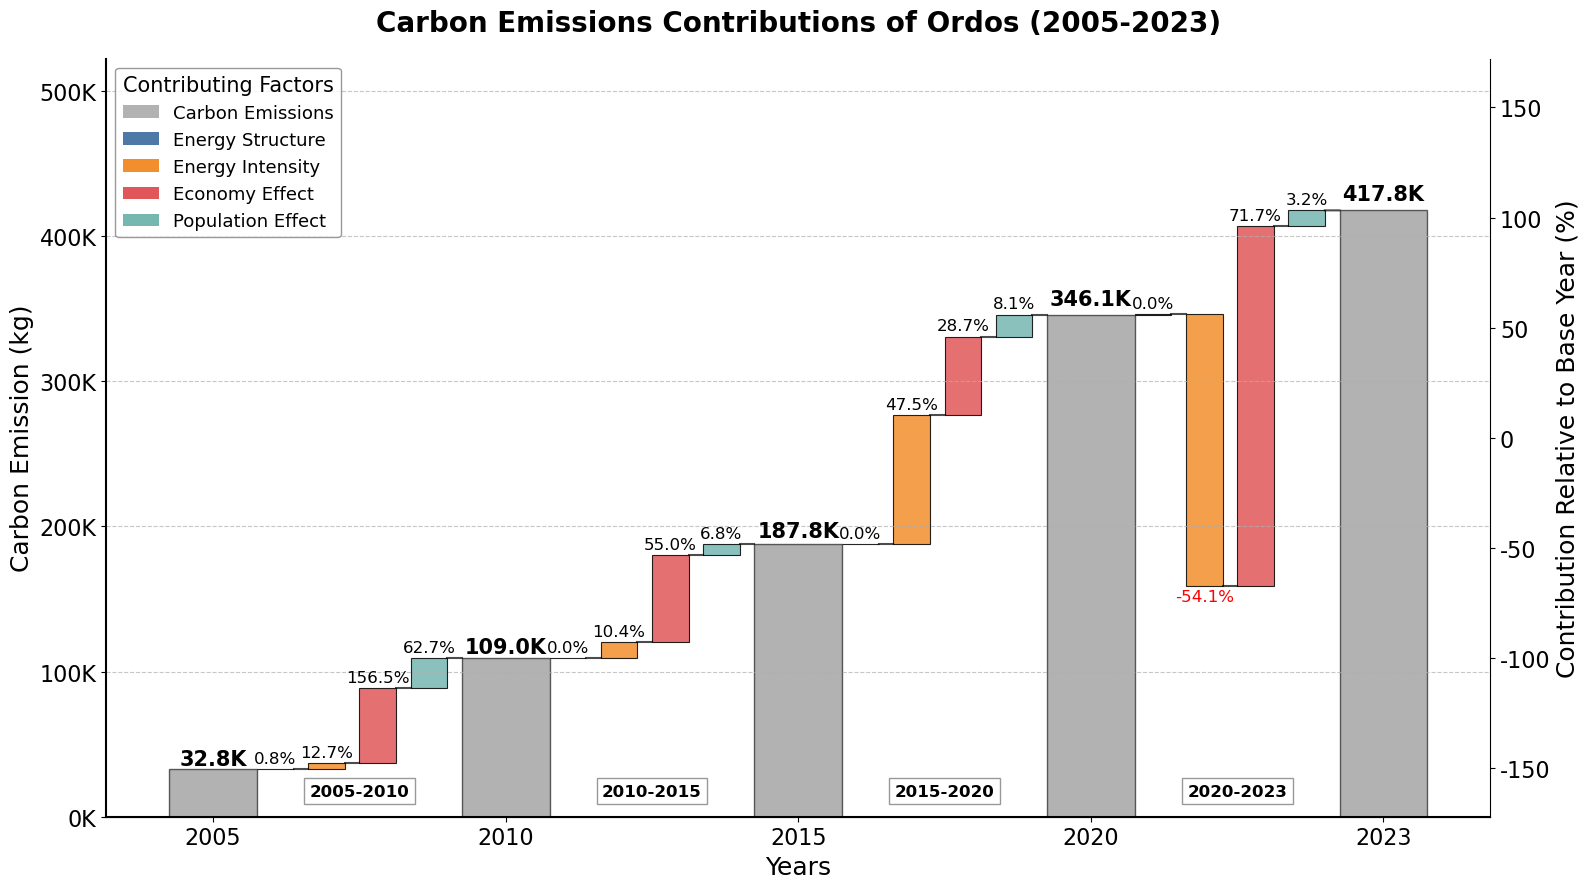

图表已保存至: 桥图/carbon_bridge_chart_ordos.png


In [30]:
# 为所有城市生成图表
draw_carbon_bridge_chart("Ordos",ordos_years, ordos_emissions, ordos_decomposition)

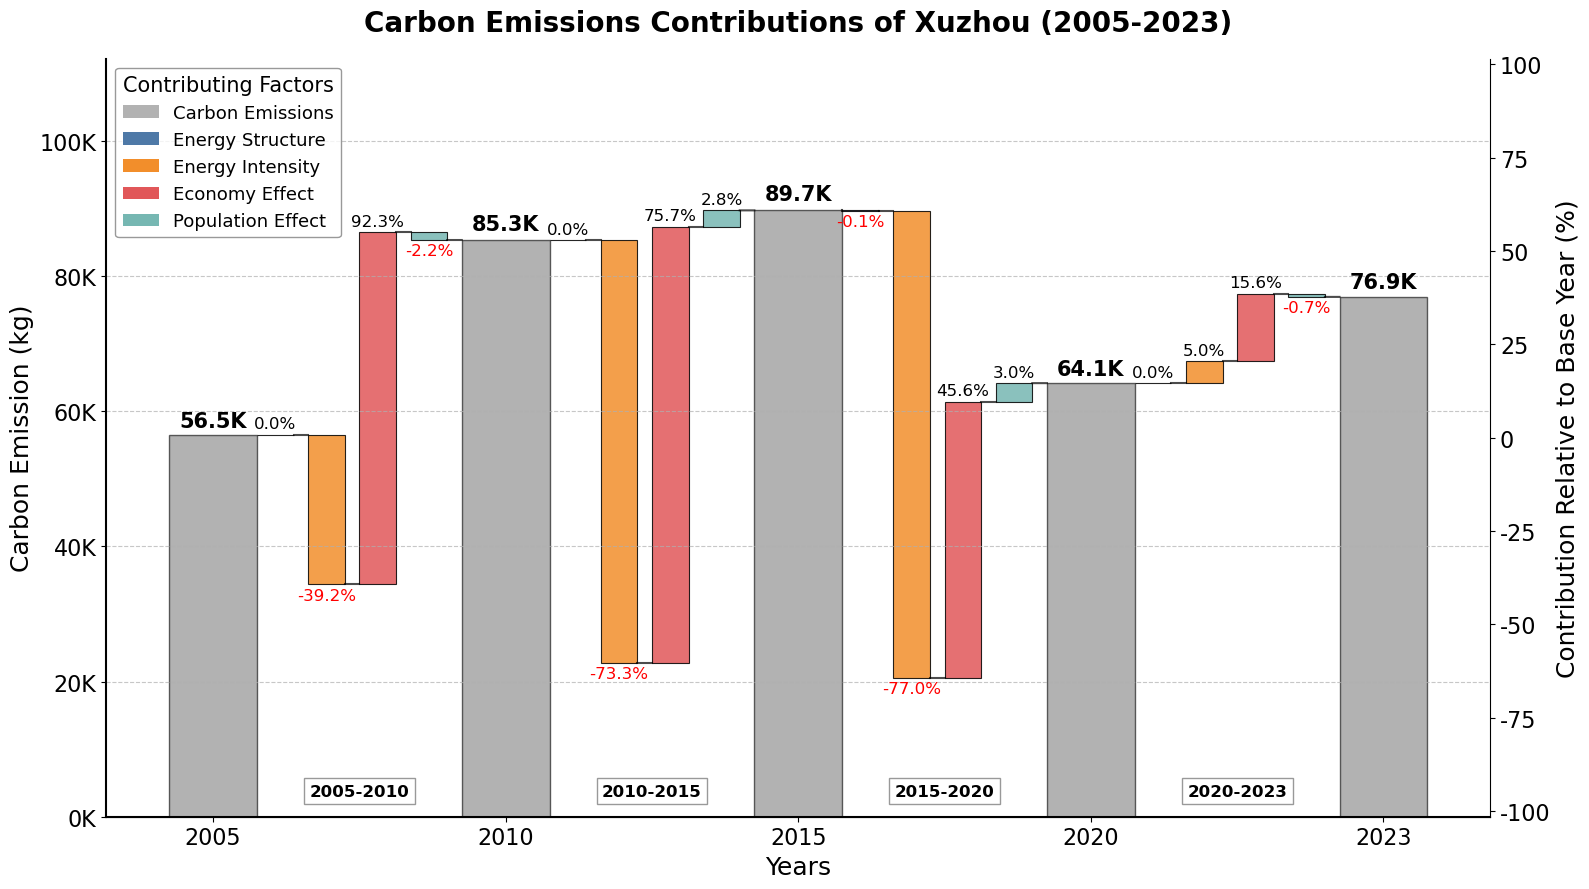

图表已保存至: 桥图/carbon_bridge_chart_xuzhou.png


In [31]:
draw_carbon_bridge_chart("Xuzhou", xuzhou_years, xuzhou_emissions, xuzhou_decomposition)

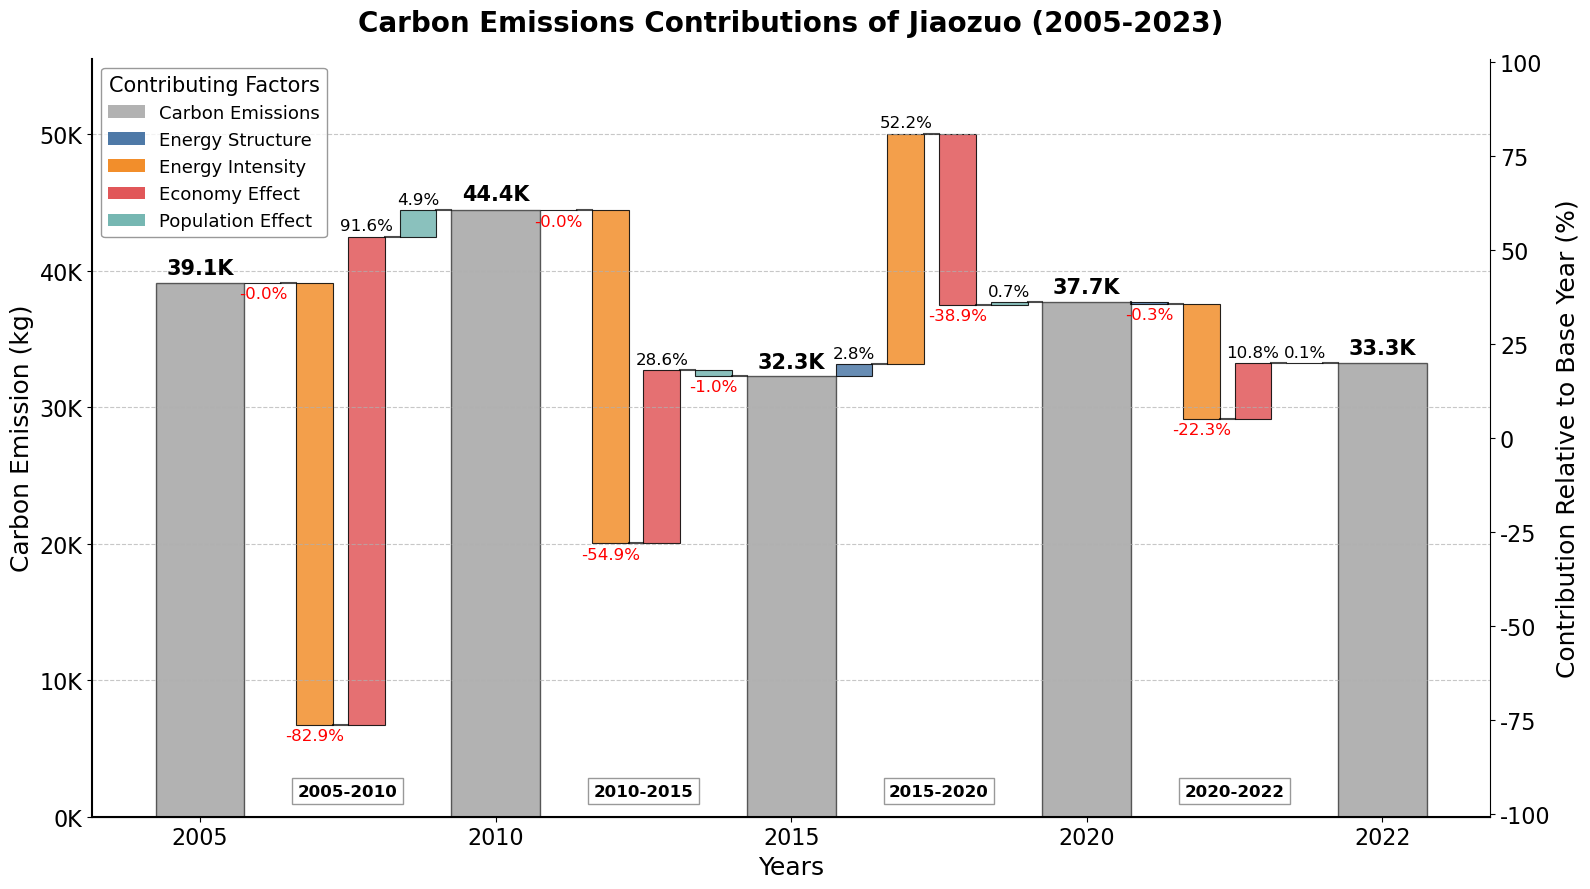

图表已保存至: 桥图/carbon_bridge_chart_jiaozuo.png


In [32]:
draw_carbon_bridge_chart("Jiaozuo", jiaozuo_years, jiaozuo_emissions, jiaozuo_decomposition)

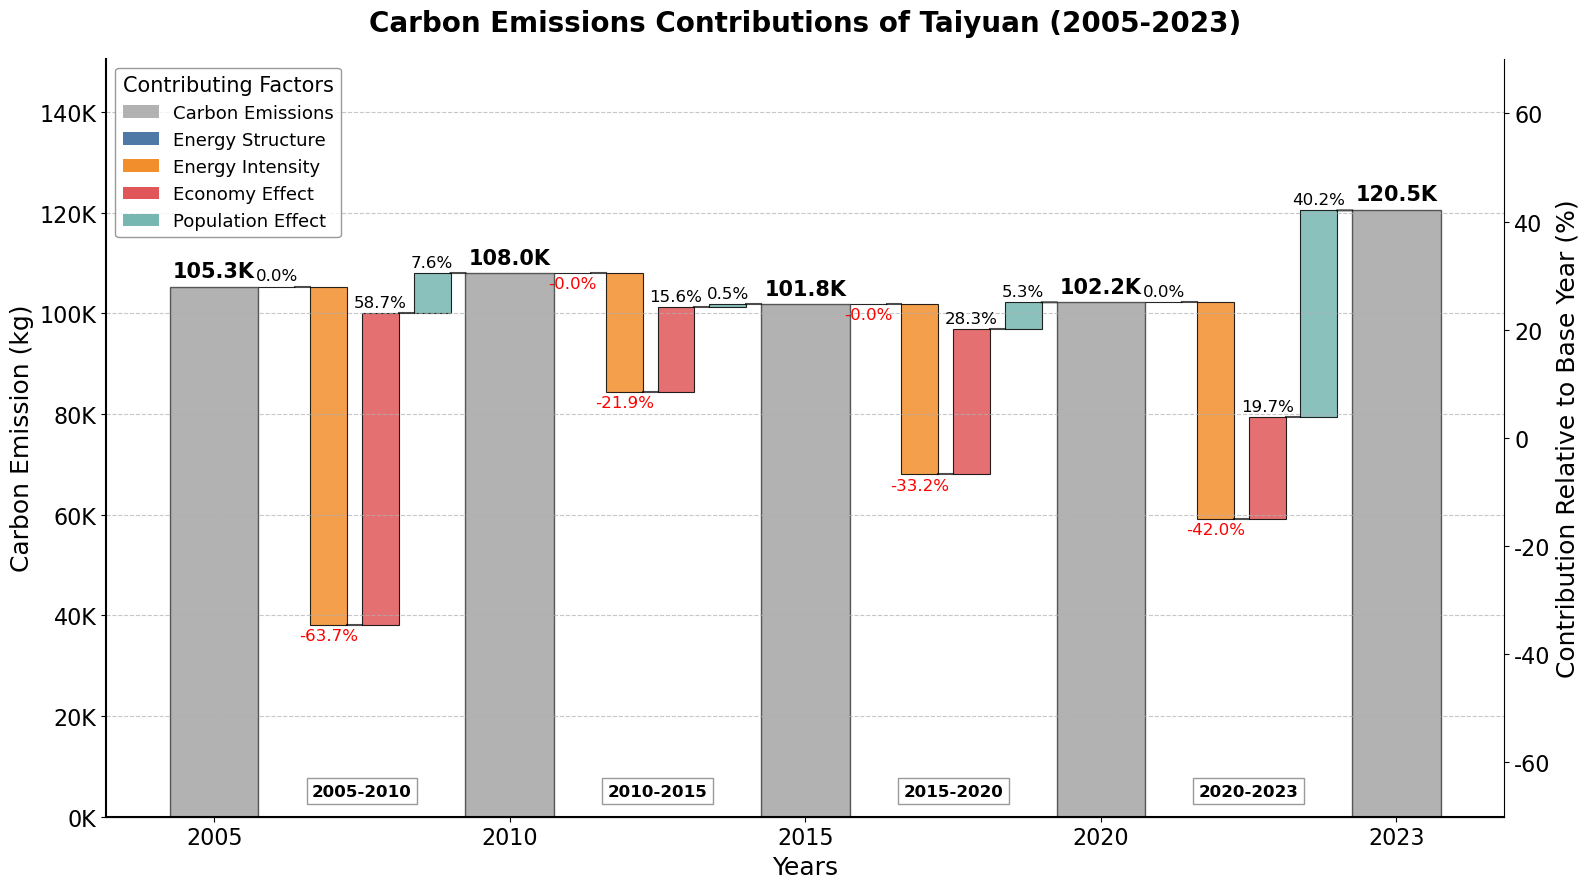

图表已保存至: 桥图/carbon_bridge_chart_taiyuan.png


In [33]:
draw_carbon_bridge_chart("Taiyuan", taiyuan_years, taiyuan_emissions, taiyuan_decomposition)